## Data Pipeline

In [1]:
!pip list

Package                      Version
---------------------------- ----------------
absl-py                      2.2.1
accelerate                   1.6.0
aiofiles                     23.2.1
albucore                     0.0.16
albumentations               1.4.15
annotated-types              0.7.0
antlr4-python3-runtime       4.9.3
anyio                        4.9.0
apyori                       1.1.2
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
attrs                        25.3.0
babel                        2.17.0
bcc                          0.18.0
beautifulsoup4               4.10.0
bitsandbytes                 0.45.4
bleach                       6.2.0
blinker                      1.9.0
Brlapi                       0.8.3
cachetools                   5.5.2
certifi                      2020.6.20
cffi                        

In [2]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tensorflow as tf
import os

2025-05-17 13:20:21.282506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747468221.303180   19813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747468221.309492   19813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747468221.325252   19813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747468221.325273   19813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747468221.325275   19813 computation_placer.cc:177] computation placer alr

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
  

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e) 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1747468224.419655   19813 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4060 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
import cv2
import imghdr

In [6]:
data_dir = "Data"
img_exts = ["jpeg","jpg","png"]

In [7]:
img_exts

['jpeg', 'jpg', 'png']

In [8]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in img_exts:
        print("Image not in ext list {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issue with image {}".format(image_path))
      #os.remove(image_path)

In [9]:
import numpy as np

In [10]:
from matplotlib import pyplot as plt

## Loading Dataset

In [11]:
data = tf.keras.utils.image_dataset_from_directory("Data")

Found 1021 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

In [14]:
batch[0].shape

(32, 256, 256, 3)

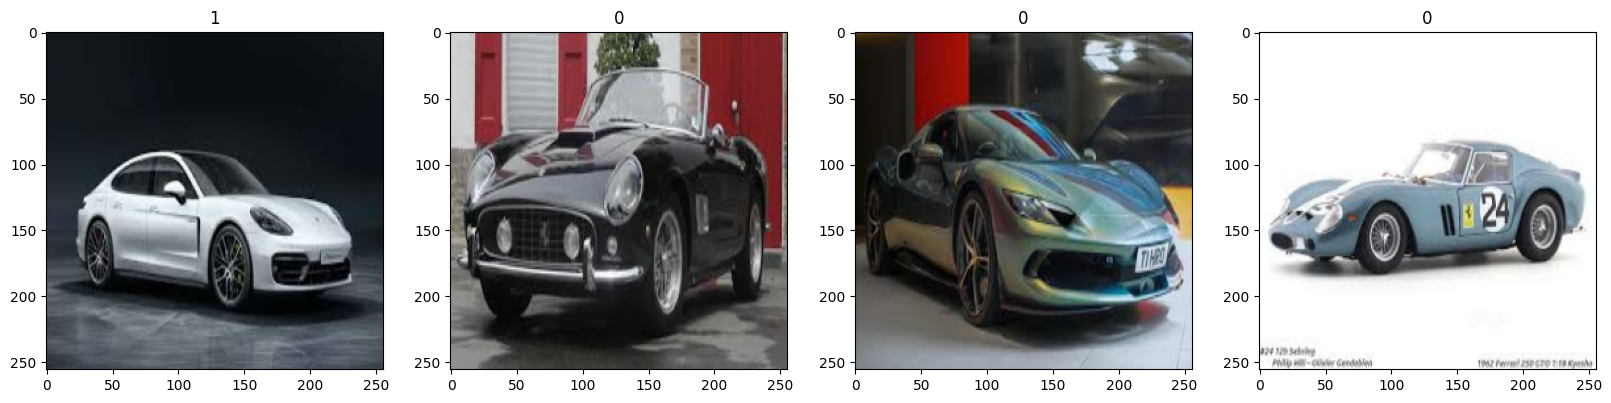

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

0 for Ferrari
1 for Porsche

In [16]:
batch[1][0:4]

array([1, 0, 0, 0], dtype=int32)

## Pre-Processing

#### Scaling data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [18]:
scaled_iterator = data.as_numpy_iterator()

In [19]:
scaled_iterator.next()[0].max()

1.0

In [20]:
len(data)

32

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:

train_size + val_size + test_size

31

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Building the Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

/home/ashishtembhekar/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.compile("adam",loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,387,649 (28.18 MB)

 Trainable params: 7,387,649 (28.18 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
logdir = "logs"

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1747468229.468124   20033 service.cc:152] XLA service 0x77926c005aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747468229.468156   20033 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-05-17 13:20:29.545743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747468229.824793   20033 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-05-17 13:20:30.411778: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,16,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %bitcast.4716, f32[16,3,3,3]{3,2,1,0} %bitcast.4723, f32[16]{0} %bitcast.5315), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4740 - loss: 1.4775

I0000 00:00:1747468235.235679   20033 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5116 - loss: 1.3621

2025-05-17 13:20:36.649899: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,16,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0} %bitcast.443, f32[16,3,3,3]{3,2,1,0} %bitcast.450, f32[16]{0} %bitcast.452), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/ashishtembhekar/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-17 13:20:36.885000: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.5130 - loss: 1.3436 - val_accuracy: 0.7760 - val_loss: 0.8525
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6896 - loss: 0.8509 - val_accuracy: 0.7344 - val_loss: 0.7125
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7188 - loss: 0.7434 - val_accuracy: 0.7344 - val_loss: 0.6747
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7552 - loss: 0.6554 - val_accuracy: 0.7708 - val_loss: 0.6208
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7458 - loss: 0.6481 - val_accuracy: 0.7552 - val_loss: 0.6106
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7901 - loss: 0.5712 - val_accuracy: 0.8177 - val_loss: 0.5631
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8246 - loss: 0.5395 - val_accuracy: 0.8021 - val_loss: 0.5564
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8397 - loss: 0.4815 - val_accuracy: 0.8281 - val_loss: 

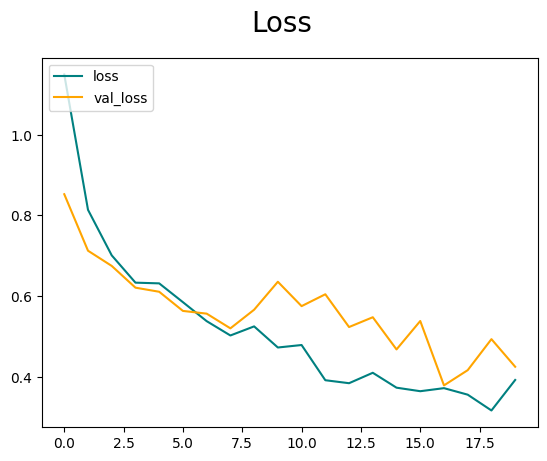

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

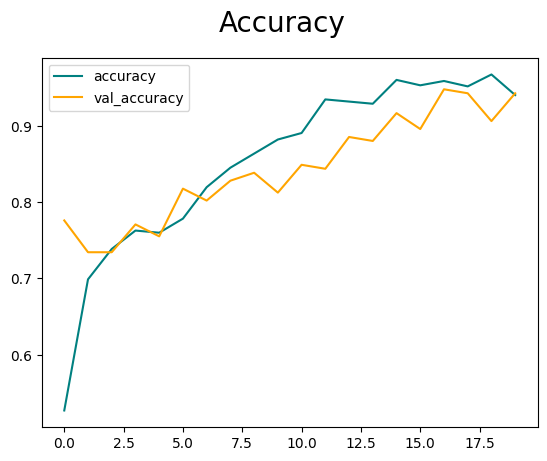

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Model Evaluation

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
len(test)

3

In [35]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2025-05-17 13:21:02.730351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9038461446762085, Recall: 0.9591836929321289, Accuracy: 0.9270833134651184


## Testing on Unseen Photos

In [37]:
import cv2

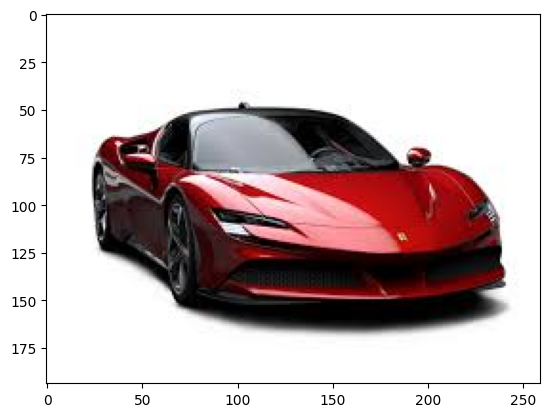

In [41]:
img = cv2.imread("sf90.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

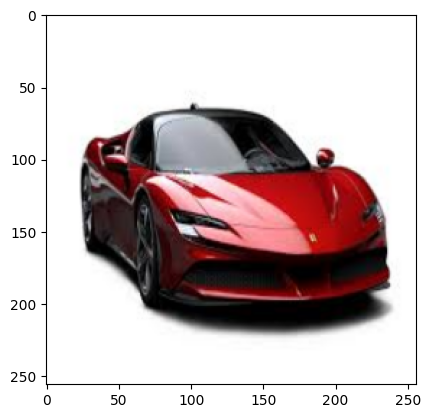

In [42]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat > 0.5:
  print(f'Predicted class is Porsche')
else:
  print(f'Predicted class is Ferrari')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[0.1553133]]
Predicted class is Ferrari


## Saving the model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','FerrariPorscheClassifier.h5'))


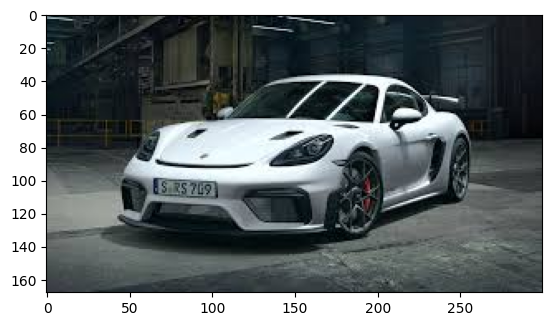

In [46]:
img = cv2.imread("gt4rs.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

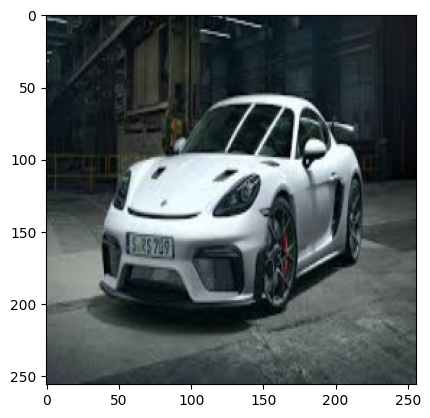

In [47]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
new_model = load_model(os.path.join('models','FerrariPorscheClassifier.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
print(yhatnew)
if yhatnew > 0.5:
  print(f'Predicted class is Porsche')
else:
  print(f'Predicted class is Ferrari')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
[[0.99986506]]
Predicted class is Porsche
